# Feature Engineering - Experience Level Classification

---

## Obiettivo

Trasformare i dati grezzi (workout_logs, workouts) in feature aggregate per utente, utilizzabili per predire experience_label.

## Flusso del Notebook

1. **EDA Pre-Engineering**: analisi dati grezzi per comprendere distribuzioni e pattern
2. **Feature Engineering**: aggregazioni statistiche per utente
3. **Validazione**: correlazioni con target, multicollinearità, qualità
4. **Export**: dataset finale per training

---

## 1. Setup e Caricamento Dati

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Setup grafico
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Funzione helper per leggere CSV con fallback nome
def read_csv_fallback(*names):
    for n in names:
        try:
            return pd.read_csv(n)
        except FileNotFoundError:
            pass
    raise FileNotFoundError(f"Nessuno trovato tra {names}")

# Carica dati
df_users = read_csv_fallback('users.csv')
df_logs = read_csv_fallback('workoutlogs.csv', 'workout_logs.csv')
df_workouts = read_csv_fallback('workouts.csv')

print("=" * 70)
print("DATI CARICATI")
print("=" * 70)
print(f"\nUsers: {df_users.shape[0]} righe x {df_users.shape[1]} colonne")
print(f"Workout logs: {df_logs.shape[0]} righe x {df_logs.shape[1]} colonne")
print(f"Workouts: {df_workouts.shape[0]} righe x {df_workouts.shape[1]} colonne")

DATI CARICATI

Users: 1000 righe x 13 colonne
Workout logs: 549282 righe x 17 colonne
Workouts: 169292 righe x 10 colonne


---
## 2. EDA Pre-Engineering

Prima di aggregare, analizziamo la distribuzione dei dati grezzi per capire:
- Come sono distribuiti i target
- Quali feature raw discriminano meglio i livelli
- Presenza di outlier o missing values

### 2.1 Distribuzione Target

DISTRIBUZIONE TARGET

Conteggi assoluti:
experience_label
Advanced        104
Beginner        345
Intermediate    551
Name: count, dtype: int64

Percentuali:
experience_label
Advanced        10.4
Beginner        34.5
Intermediate    55.1
Name: count, dtype: float64


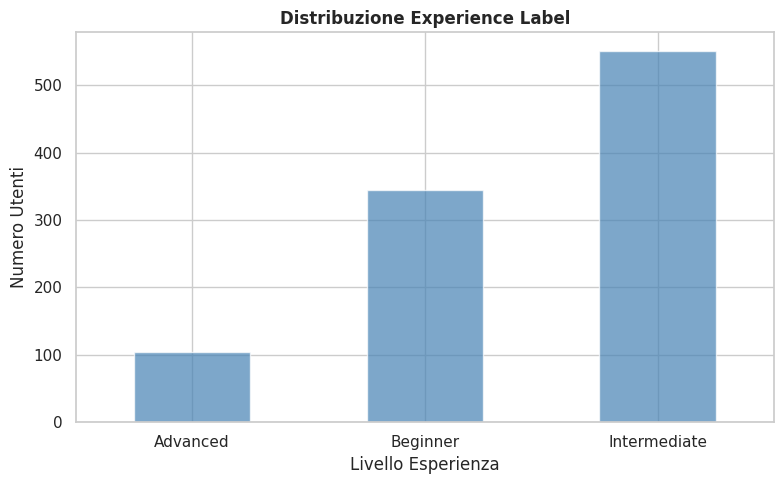


Ratio max/min: 5.30
Dataset sbilanciato: classe maggioritaria 5.3x più grande


In [3]:
print("=" * 70)
print("DISTRIBUZIONE TARGET")
print("=" * 70)

target_dist = df_users['experience_label'].value_counts().sort_index()
print("\nConteggi assoluti:")
print(target_dist)
print(f"\nPercentuali:")
print((target_dist / target_dist.sum() * 100).round(2))

# Grafico
fig, ax = plt.subplots(figsize=(8, 5))
target_dist.plot(kind='bar', color='steelblue', alpha=0.7, ax=ax)
ax.set_xlabel('Livello Esperienza')
ax.set_ylabel('Numero Utenti')
ax.set_title('Distribuzione Experience Label', fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Valutazione bilanciamento
ratio = target_dist.max() / target_dist.min()
print(f"\nRatio max/min: {ratio:.2f}")
if ratio < 2:
    print("Dataset relativamente bilanciato (ratio < 2)")
else:
    print(f"Dataset sbilanciato: classe maggioritaria {ratio:.1f}x più grande")

### 2.2 Feature Raw - Boxplot per Livello

DISTRIBUZIONE FEATURE RAW PER LIVELLO


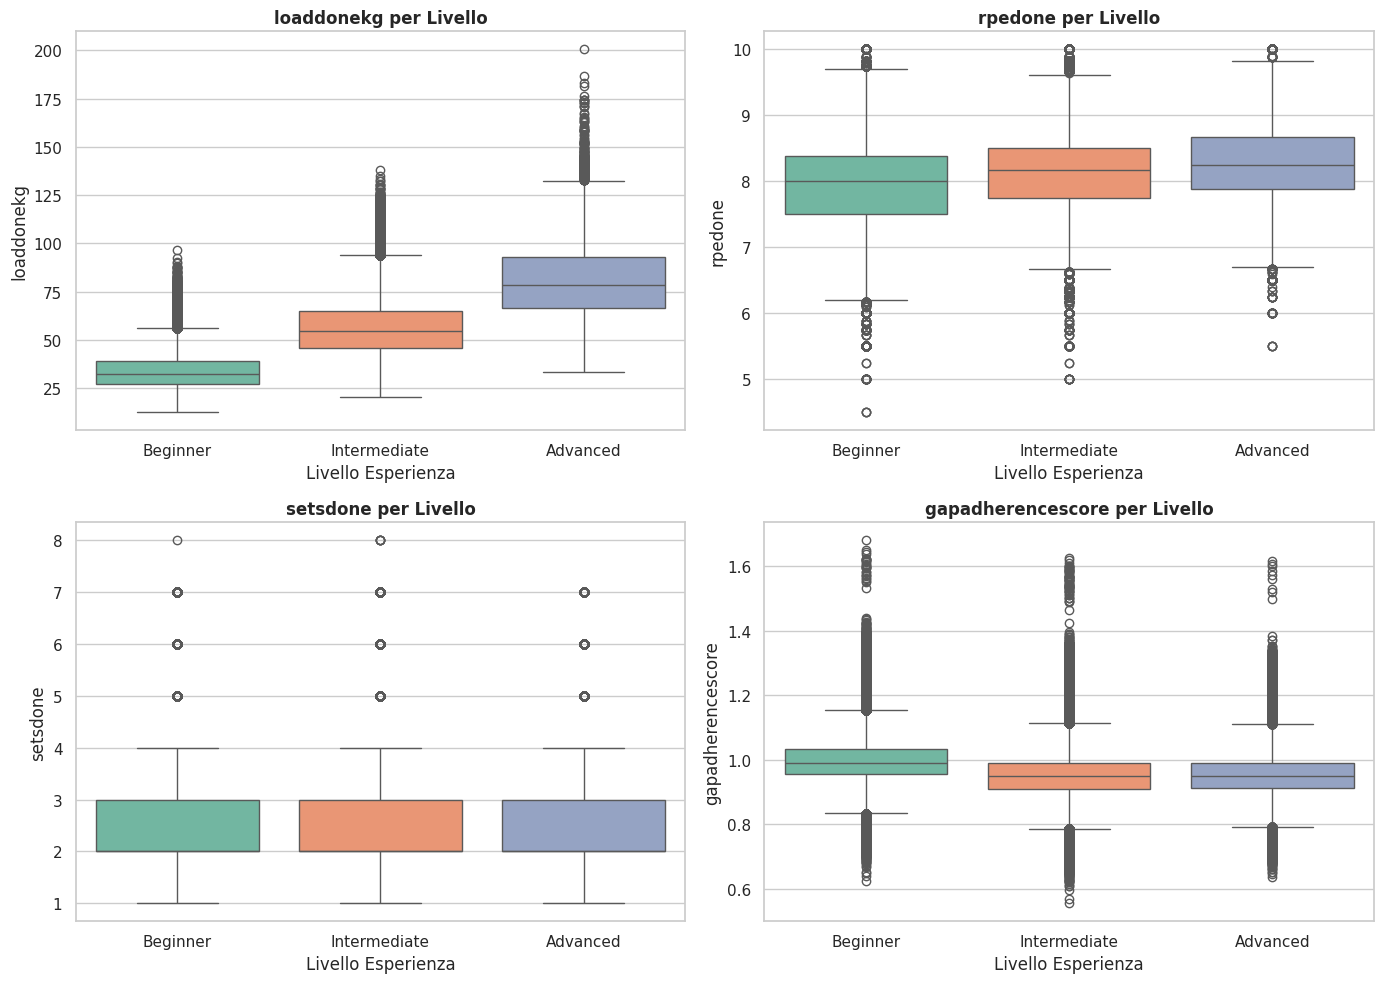


Osservazioni:
- loaddonekg: Advanced solleva carichi significativamente maggiori
- rpedone: Advanced mantiene RPE elevati (maggiore intensità percepita)
- setsdone: distribuzione simile tra livelli (volume di lavoro)
- gapadherencescore: Advanced più consistente (meno variabilità)


In [4]:
print("=" * 70)
print("DISTRIBUZIONE FEATURE RAW PER LIVELLO")
print("=" * 70)

# Merge per avere livello esperienza
df_logs_labeled = df_logs.merge(
    df_users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

# Feature da analizzare
features_raw = ['loaddonekg', 'rpedone', 'setsdone', 'gapadherencescore']

# Boxplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(features_raw):
    sns.boxplot(
        data=df_logs_labeled,
        x='experience_label',
        y=feat,
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f'{feat} per Livello', fontweight='bold')
    axes[i].set_xlabel('Livello Esperienza')

plt.tight_layout()
plt.show()

print("\nOsservazioni:")
print("- loaddonekg: Advanced solleva carichi significativamente maggiori")
print("- rpedone: Advanced mantiene RPE elevati (maggiore intensità percepita)")
print("- setsdone: distribuzione simile tra livelli (volume di lavoro)")
print("- gapadherencescore: Advanced più consistente (meno variabilità)")

### 2.3 Qualità Dati - Missing Values e Outlier

In [5]:
print("=" * 70)
print("QUALITA' DATI GREZZI")
print("=" * 70)

print("\n1. Missing Values:")
missing_logs = df_logs.isnull().sum()
if missing_logs.sum() == 0:
    print("   Nessun missing value in workout_logs")
else:
    print("   Colonne con missing:")
    print(missing_logs[missing_logs > 0])

missing_workouts = df_workouts.isnull().sum()
if missing_workouts.sum() == 0:
    print("   Nessun missing value in workouts")
else:
    print("   Colonne con missing:")
    print(missing_workouts[missing_workouts > 0])

print("\n2. Outlier Detection (metodo IQR):")
for feat in ['loaddonekg', 'rpedone', 'gapadherencescore']:
    Q1 = df_logs[feat].quantile(0.25)
    Q3 = df_logs[feat].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_logs[feat] < Q1 - 1.5*IQR) | (df_logs[feat] > Q3 + 1.5*IQR)).sum()
    print(f"   {feat}: {outliers} outlier ({100*outliers/len(df_logs):.2f}%)")

print("\nDecisione: manteniamo gli outlier")
print("Motivazione: carichi estremi potrebbero rappresentare utenti Advanced reali")

QUALITA' DATI GREZZI

1. Missing Values:
   Colonne con missing:
loaddonekg     983
rpedone       2024
dtype: int64
   Nessun missing value in workouts

2. Outlier Detection (metodo IQR):
   loaddonekg: 7831 outlier (1.43%)
   rpedone: 4409 outlier (0.80%)
   gapadherencescore: 36316 outlier (6.61%)

Decisione: manteniamo gli outlier
Motivazione: carichi estremi potrebbero rappresentare utenti Advanced reali


### 2.4 Sessioni Done vs Skipped

ANALISI ADERENZA: SESSIONI DONE VS SKIPPED

Distribuzione sessioni:
workoutstatus
done       152185
skipped     17107
Name: count, dtype: int64

Tasso completamento: 89.89%


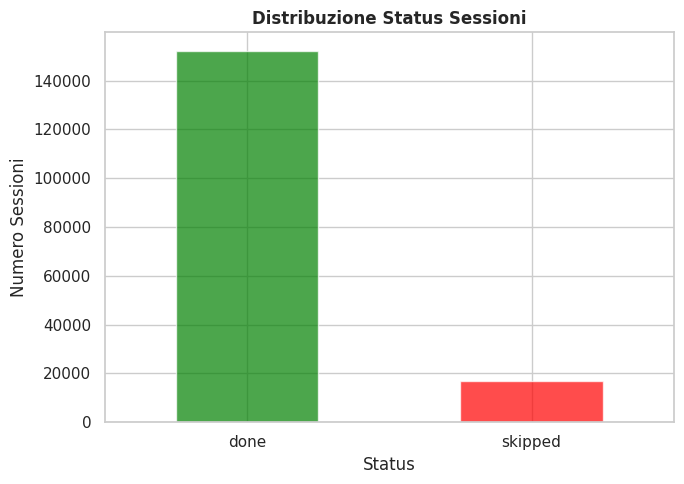


Implicazioni:
- skip_rate sarà una feature importante (aderenza al programma)
- Utenti Advanced potrebbero avere skip_rate più basso (maggiore disciplina)


In [6]:
print("=" * 70)
print("ANALISI ADERENZA: SESSIONI DONE VS SKIPPED")
print("=" * 70)

status_counts = df_workouts['workoutstatus'].value_counts()
print("\nDistribuzione sessioni:")
print(status_counts)
print(f"\nTasso completamento: {100 * status_counts.get('done', 0) / len(df_workouts):.2f}%")

# Grafico
fig, ax = plt.subplots(figsize=(7, 5))
status_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7, ax=ax)
ax.set_xlabel('Status')
ax.set_ylabel('Numero Sessioni')
ax.set_title('Distribuzione Status Sessioni', fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nImplicazioni:")
print("- skip_rate sarà una feature importante (aderenza al programma)")
print("- Utenti Advanced potrebbero avere skip_rate più basso (maggiore disciplina)")

---
## 3. Feature Engineering

Aggreghiamo i dati raw per utente, creando:
- **Statistiche descrittive**: mean, std, max, min (intensità e consistenza)
- **Feature derivate**: coefficienti di variazione (CV = std/mean)
- **Feature comportamentali**: skip_rate, sessions_total

### 3.1 Aggregazione workout_logs per Utente

In [7]:
print("=" * 70)
print("AGGREGAZIONE workout_logs per userid")
print("=" * 70)

# Aggregazione
features_from_logs = df_logs.groupby('userid').agg({
    'loaddonekg': ['mean', 'std', 'max', 'min'],
    'rpedone': ['mean', 'std'],
    'setsdone': 'sum',
    'repsdoneavg': 'mean',
    'repsdonetotal': 'sum',
    'gapadherencescore': ['mean', 'std']
}).reset_index()

# Flatten columns
features_from_logs.columns = ['_'.join(col).strip('_') for col in features_from_logs.columns.values]

# Rinomina
features_from_logs.columns = [
    'userid',
    'load_mean', 'load_std', 'load_max', 'load_min',
    'rpe_mean', 'rpe_std',
    'sets_total',
    'reps_avg',
    'reps_total',
    'gap_mean', 'gap_std'
]

print(f"\nFeature create: {len(features_from_logs.columns) - 1}")
print(f"Utenti: {len(features_from_logs)}")
print("\nPrime 3 righe:")
print(features_from_logs.head(3))

AGGREGAZIONE workout_logs per userid

Feature create: 11
Utenti: 1000

Prime 3 righe:
   userid  load_mean   load_std  load_max  load_min  rpe_mean   rpe_std  \
0       1  35.387702   9.261530     64.25     16.75  7.246451  0.502289   
1       2  55.071283  10.936000     89.12     33.12  8.423310  0.582446   
2       3  28.904789   7.168496     52.12     15.25  8.068542  0.564518   

   sets_total   reps_avg  reps_total  gap_mean   gap_std  
0        2212   9.398614       19995  1.003782  0.090295  
1        2515   9.458312       22772  0.956215  0.087853  
2         329  10.220903        3195  0.997424  0.081200  


### 3.2 Aggregazione workouts per Utente

In [8]:
print("=" * 70)
print("AGGREGAZIONE workouts per userid")
print("=" * 70)

features_from_workouts = df_workouts.groupby('userid').agg({
    'workoutid': 'count',
    'workoutstatus': lambda x: (x == 'done').sum()
}).reset_index()

features_from_workouts.columns = ['userid', 'sessions_total', 'sessions_done']

# Calcola skip rate
features_from_workouts['sessions_skipped'] = (
    features_from_workouts['sessions_total'] - features_from_workouts['sessions_done']
)
features_from_workouts['skip_rate'] = (
    features_from_workouts['sessions_skipped'] / features_from_workouts['sessions_total']
)

print(f"\nFeature create: {len(features_from_workouts.columns) - 1}")
print(f"Utenti: {len(features_from_workouts)}")
print("\nPrime 3 righe:")
print(features_from_workouts.head(3))

AGGREGAZIONE workouts per userid

Feature create: 4
Utenti: 1000

Prime 3 righe:
   userid  sessions_total  sessions_done  sessions_skipped  skip_rate
0       1             273            236                37   0.135531
1       2             336            299                37   0.110119
2       3              50             40                10   0.200000


### 3.3 Feature Derivate - Coefficienti di Variazione

In [9]:
print("=" * 70)
print("FEATURE DERIVATE")
print("=" * 70)

# Coefficiente di variazione (CV = std/mean)
# Misura consistenza: CV basso = più consistente

features_from_logs['load_cv'] = features_from_logs['load_std'] / features_from_logs['load_mean']
features_from_logs['rpe_cv'] = features_from_logs['rpe_std'] / features_from_logs['rpe_mean']
features_from_logs['gap_cv'] = features_from_logs['gap_std'] / features_from_logs['gap_mean']

# Gestisci divisioni per zero o NaN
features_from_logs = features_from_logs.fillna(0)
features_from_logs = features_from_logs.replace([np.inf, -np.inf], 0)

print("\nFeature derivate aggiunte:")
print("  - load_cv (coefficiente variazione carico)")
print("  - rpe_cv (coefficiente variazione RPE)")
print("  - gap_cv (coefficiente variazione aderenza)")
print("\nQueste misurano la CONSISTENZA dell'utente")
print("CV basso = comportamento più stabile e prevedibile")

FEATURE DERIVATE

Feature derivate aggiunte:
  - load_cv (coefficiente variazione carico)
  - rpe_cv (coefficiente variazione RPE)
  - gap_cv (coefficiente variazione aderenza)

Queste misurano la CONSISTENZA dell'utente
CV basso = comportamento più stabile e prevedibile


### 3.4 Merge Finale - Dataset Completo

In [10]:
print("=" * 70)
print("UNIONE FEATURE + TARGET")
print("=" * 70)

# Prendi target da users
df_final = df_users[['userid', 'experience_label']].copy()

# Merge feature da logs
df_final = df_final.merge(features_from_logs, on='userid', how='left')

# Merge feature da workouts
df_final = df_final.merge(features_from_workouts, on='userid', how='left')

# Gestisci NaN (utenti senza dati)
df_final = df_final.fillna(0)

print(f"\nDataset finale:")
print(f"  Righe: {len(df_final)} (1 riga = 1 utente)")
print(f"  Colonne: {len(df_final.columns)}")
print(f"\nTarget: experience_label")
print(f"Feature: {len(df_final.columns) - 2} (esclusi userid e target)")
print("\nPrime 3 righe:")
print(df_final.head(3))

UNIONE FEATURE + TARGET

Dataset finale:
  Righe: 1000 (1 riga = 1 utente)
  Colonne: 20

Target: experience_label
Feature: 18 (esclusi userid e target)

Prime 3 righe:
   userid experience_label  load_mean   load_std  load_max  load_min  \
0       1         Beginner  35.387702   9.261530     64.25     16.75   
1       2     Intermediate  55.071283  10.936000     89.12     33.12   
2       3         Beginner  28.904789   7.168496     52.12     15.25   

   rpe_mean   rpe_std  sets_total   reps_avg  reps_total  gap_mean   gap_std  \
0  7.246451  0.502289        2212   9.398614       19995  1.003782  0.090295   
1  8.423310  0.582446        2515   9.458312       22772  0.956215  0.087853   
2  8.068542  0.564518         329  10.220903        3195  0.997424  0.081200   

    load_cv    rpe_cv    gap_cv  sessions_total  sessions_done  \
0  0.261716  0.069315  0.089955             273            236   
1  0.198579  0.069147  0.091875             336            299   
2  0.248004  0.069965  

---
## 4. Validazione Post-Engineering

Verifichiamo:
- Quali feature sono più correlate con il target
- Presenza di multicollinearità (ridondanza tra feature)
- Qualità del dataset finale

### 4.1 Correlazioni con Target

CORRELAZIONI CON TARGET

Top 10 feature più correlate con target:
gap_mean            0.391
skip_rate           0.152
gap_cv              0.094
rpe_mean            0.079
rpe_cv              0.076
sessions_skipped    0.069
reps_avg            0.055
rpe_std             0.043
sets_total          0.041
reps_total          0.038
Name: target_encoded, dtype: float64


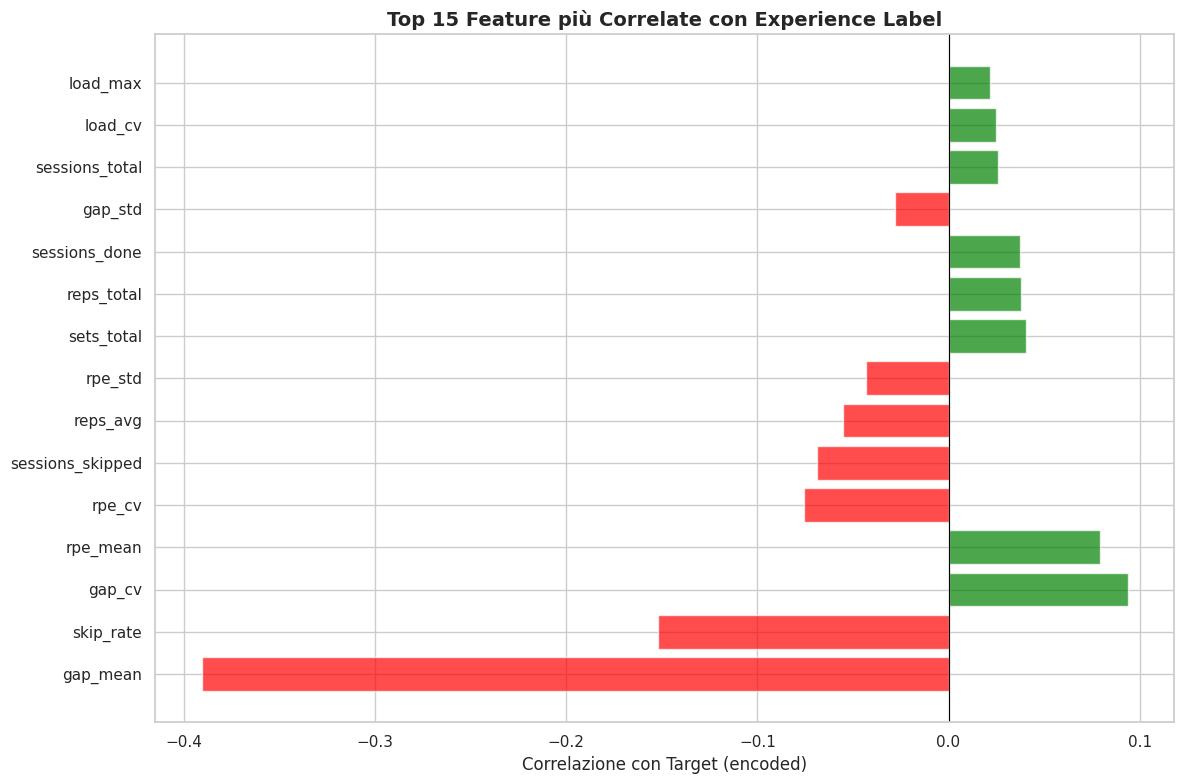


Interpretazione:
- Correlazione positiva: aumenta con il livello (Beginner < Intermediate < Advanced)
- Correlazione negativa: diminuisce con il livello
- Valore assoluto > 0.3: correlazione moderata/forte


In [11]:
print("=" * 70)
print("CORRELAZIONI CON TARGET")
print("=" * 70)

# Encode target per correlazione
le = LabelEncoder()
df_final['target_encoded'] = le.fit_transform(df_final['experience_label'])

# Correlazioni
feature_cols = [col for col in df_final.columns
                if col not in ['userid', 'experience_label', 'target_encoded']]

corr_with_target = df_final[feature_cols + ['target_encoded']].corr()['target_encoded'].drop('target_encoded')
corr_sorted = corr_with_target.abs().sort_values(ascending=False)

print("\nTop 10 feature più correlate con target:")
print(corr_sorted.head(10).round(3))

# Grafico
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
top15 = corr_sorted.head(15)
colors = ['green' if corr_with_target[idx] > 0 else 'red' for idx in top15.index]
ax.barh(range(len(top15)), corr_with_target[top15.index], color=colors, alpha=0.7)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15.index)
ax.set_xlabel('Correlazione con Target (encoded)')
ax.set_title('Top 15 Feature più Correlate con Experience Label', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nInterpretazione:")
print("- Correlazione positiva: aumenta con il livello (Beginner < Intermediate < Advanced)")
print("- Correlazione negativa: diminuisce con il livello")
print("- Valore assoluto > 0.3: correlazione moderata/forte")

### 4.2 Multicollinearità - Heatmap Correlazioni tra Feature

MULTICOLLINEARITA' - CORRELAZIONI TRA FEATURE


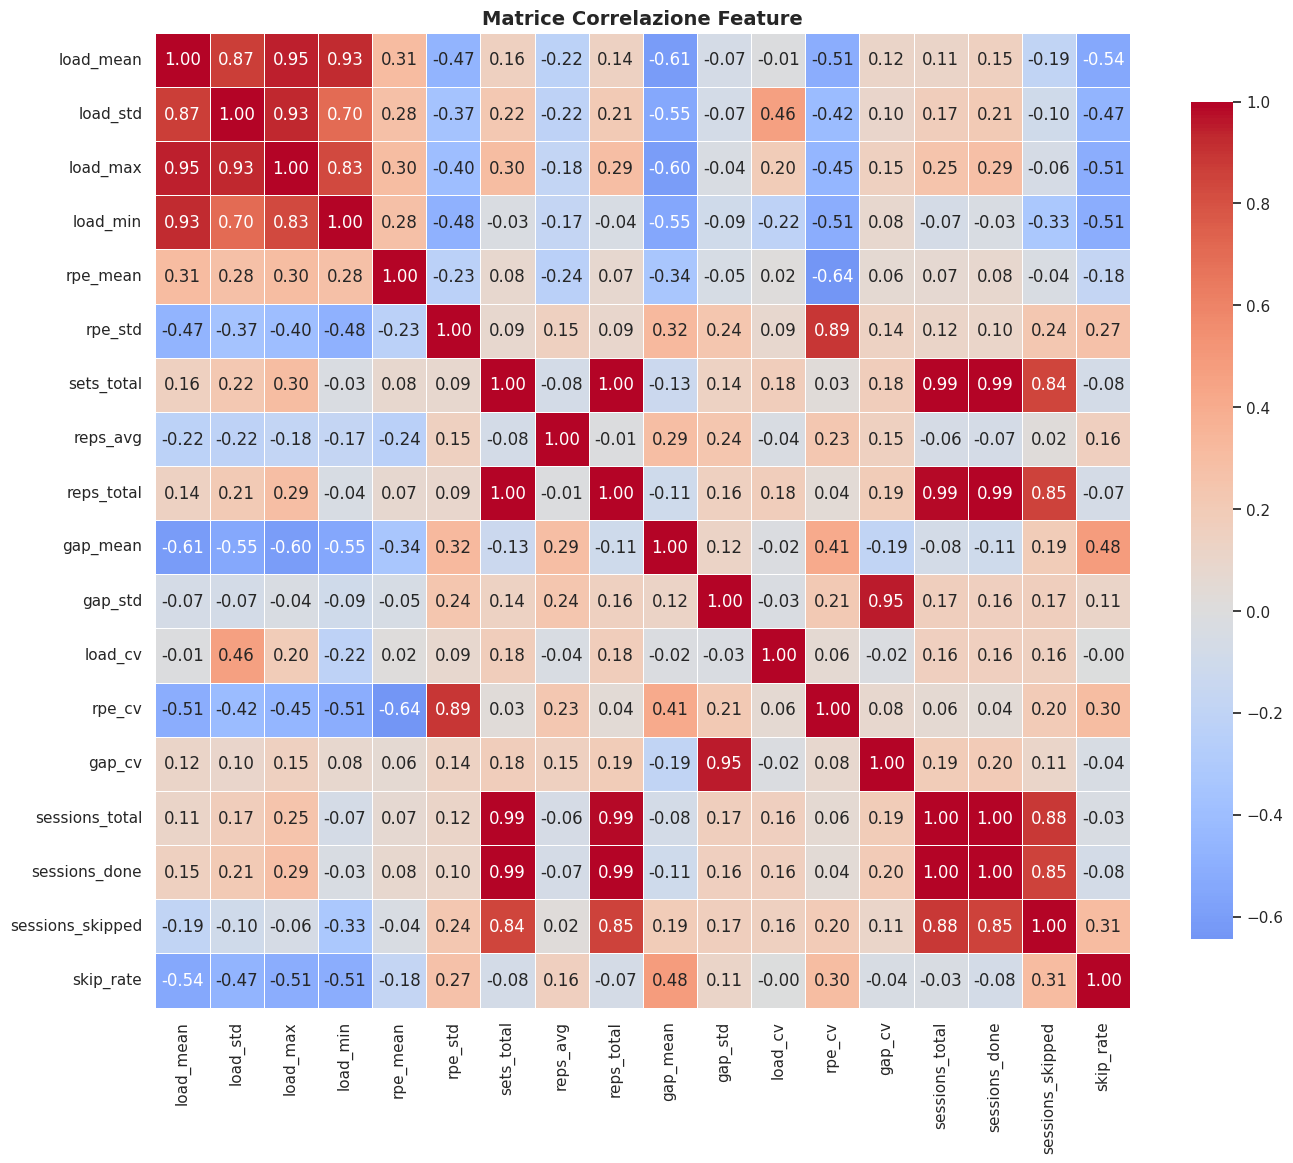


Feature altamente correlate (|r| > 0.8):
  load_mean <-> load_std: 0.869
  load_mean <-> load_max: 0.948
  load_mean <-> load_min: 0.928
  load_std <-> load_max: 0.933
  load_max <-> load_min: 0.833
  rpe_std <-> rpe_cv: 0.892
  sets_total <-> reps_total: 0.997
  sets_total <-> sessions_total: 0.987
  sets_total <-> sessions_done: 0.989
  sets_total <-> sessions_skipped: 0.842
  reps_total <-> sessions_total: 0.986
  reps_total <-> sessions_done: 0.987
  reps_total <-> sessions_skipped: 0.846
  gap_std <-> gap_cv: 0.950
  sessions_total <-> sessions_done: 0.998
  sessions_total <-> sessions_skipped: 0.882
  sessions_done <-> sessions_skipped: 0.852

Considerazione: valutare rimozione di una delle feature ridondanti


In [12]:
print("=" * 70)
print("MULTICOLLINEARITA' - CORRELAZIONI TRA FEATURE")
print("=" * 70)

# Matrice di correlazione
corr_matrix = df_final[feature_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matrice Correlazione Feature', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\nFeature altamente correlate (|r| > 0.8):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append(
                f"  {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}"
            )

if len(high_corr) == 0:
    print("  Nessuna (ottimo: no ridondanza significativa)")
else:
    for pair in high_corr:
        print(pair)
    print("\nConsiderazione: valutare rimozione di una delle feature ridondanti")

### 4.3 Verifica Qualità Dataset Finale

In [17]:
print("=" * 70)
print("VERIFICA QUALITA' DATASET FINALE")
print("=" * 70)

print("\n1. Missing values:")
missing = df_final.drop('target_encoded', axis=1).isnull().sum().sum()
print(f"   Totale: {missing}")

print("\n2. Distribuzione target:")
target_dist = df_final['experience_label'].value_counts().sort_index()
print(target_dist)

print("\n3. Feature con varianza zero:")
zero_var = [col for col in feature_cols if df_final[col].std() == 0]
if len(zero_var) == 0:
    print("   Nessuna (bene: tutte le feature sono informative)")
else:
    print(f"   {zero_var}")
    print("   Consiglio: rimuovere prima del training")

print("\n4. Range feature principali:")
for col in ['loadmean', 'rpemean', 'skiprate', 'gapmean']:
    if col in df_final.columns:
        print(f"   {col}: [{df_final[col].min():.2f}, {df_final[col].max():.2f}]")

print("\n5. Statistiche descrittive:")
print(df_final[feature_cols].describe().round(2))

VERIFICA QUALITA' DATASET FINALE

1. Missing values:
   Totale: 0

2. Distribuzione target:
experience_label
Advanced        104
Beginner        345
Intermediate    551
Name: count, dtype: int64

3. Feature con varianza zero:
   Nessuna (bene: tutte le feature sono informative)

4. Range feature principali:

5. Statistiche descrittive:
       load_mean  load_std  load_max  load_min  rpe_mean  rpe_std  sets_total  \
count    1000.00   1000.00   1000.00   1000.00   1000.00  1000.00     1000.00   
mean       49.71     11.03     80.34     28.31      8.06     0.53     1401.32   
std        14.90      3.75     25.32      8.88      0.39     0.04      880.64   
min        25.77      4.25     39.00     12.50      6.80     0.36       35.00   
25%        33.72      7.93     56.25     19.72      7.79     0.50      669.75   
50%        52.14     10.77     81.18     29.25      8.07     0.53     1310.00   
75%        57.57     13.41     96.03     33.38      8.31     0.56     2024.25   
max        97.

---
## 5. Export e Riepilogo

### 5.1 Salva Dataset

In [16]:
# Rimuovi colonna temporanea target_encoded
df_export = df_final.drop('target_encoded', axis=1)

# Salva
output_file = 'STATUS_final.csv'
df_export.to_csv(output_file, index=False)

print("=" * 70)
print("DATASET SALVATO")
print("=" * 70)
print(f"\nFile: {output_file}")
print(f"Righe: {len(df_export)}")
print(f"Colonne: {len(df_export.columns)}")
print(f"\nColonne:")
for i, col in enumerate(df_export.columns, 1):
    print(f"  {i}. {col}")

DATASET SALVATO

File: STATUS_final.csv
Righe: 1000
Colonne: 20

Colonne:
  1. userid
  2. experience_label
  3. load_mean
  4. load_std
  5. load_max
  6. load_min
  7. rpe_mean
  8. rpe_std
  9. sets_total
  10. reps_avg
  11. reps_total
  12. gap_mean
  13. gap_std
  14. load_cv
  15. rpe_cv
  16. gap_cv
  17. sessions_total
  18. sessions_done
  19. sessions_skipped
  20. skip_rate


### 5.2 Riepilogo Finale

In [18]:
print("=" * 70)
print("RIEPILOGO FEATURE ENGINEERING")
print("=" * 70)

print("\n1. DATI INPUT:")
print(f"   - {len(df_users)} utenti")
print(f"   - {len(df_logs)} log esercizi")
print(f"   - {len(df_workouts)} sessioni")

print("\n2. FEATURE CREATE:")
print(f"   - {len(df_export.columns) - 2} feature totali")
print("   - Statistiche descrittive: mean, std, max, min")
print("   - Coefficienti di variazione: load_cv, rpe_cv, gap_cv")
print("   - Comportamentali: skip_rate, sessions_total, sessions_done")

print("\n3. FEATURE PIU' CORRELATE CON TARGET:")
top5 = corr_sorted.head(5)
for feat, corr_val in top5.items():
    print(f"   - {feat}: {corr_val:.3f}")

print("\n4. QUALITA':")
print(f"   - Missing values: {missing}")
print(f"   - Feature con varianza zero: {len(zero_var)}")
print(f"   - Dataset bilanciato: {'Sì' if target_dist.max() / target_dist.min() < 2 else 'No'}")

RIEPILOGO FEATURE ENGINEERING

1. DATI INPUT:
   - 1000 utenti
   - 549282 log esercizi
   - 169292 sessioni

2. FEATURE CREATE:
   - 18 feature totali
   - Statistiche descrittive: mean, std, max, min
   - Coefficienti di variazione: load_cv, rpe_cv, gap_cv
   - Comportamentali: skip_rate, sessions_total, sessions_done

3. FEATURE PIU' CORRELATE CON TARGET:
   - gap_mean: 0.391
   - skip_rate: 0.152
   - gap_cv: 0.094
   - rpe_mean: 0.079
   - rpe_cv: 0.076

4. QUALITA':
   - Missing values: 0
   - Feature con varianza zero: 0
   - Dataset bilanciato: No
